In [26]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [64]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder,  minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2, VGG16

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

1. Bu kod, balık veri kümesindeki alt klasörleri (balık türlerini) bulup bir listeye kaydeder. Bu klasör isimleri, sınıf etiketleri olarak kullanılacaktır.

In [29]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(fish_dir) if                                                                                                                                                                                                                                                                                                                                                            '.' not in i]                    
classes


['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

2. Bu kod, balık resimlerinin dosya yollarını ve etiketlerini toplayarak bir DataFrame'e kaydeder. Ardından, her balık türünden kaç tane resim olduğunu sayar.

In [30]:
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label 
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

In [31]:
data.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


3. Bu kod, `data` adlı DataFrame'deki satır (görüntü sayısı) ve sütun (özellik sayısı) miktarını ekrana yazdırır.

In [32]:
print(f" Count of Rows : {data.shape[0]} \n Count of Columns : {data.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


4. Bu kod, `data` DataFrame'indeki ilk 9 görüntüyü ve etiketlerini 3x3'lük bir grid üzerinde gösterir. Görüntüler 224x224 boyutuna ayarlanıp normalize edildikten sonra, her birine ait etiket başlık olarak eklenir ve görseller eksensiz olarak ekranda gösterilir.

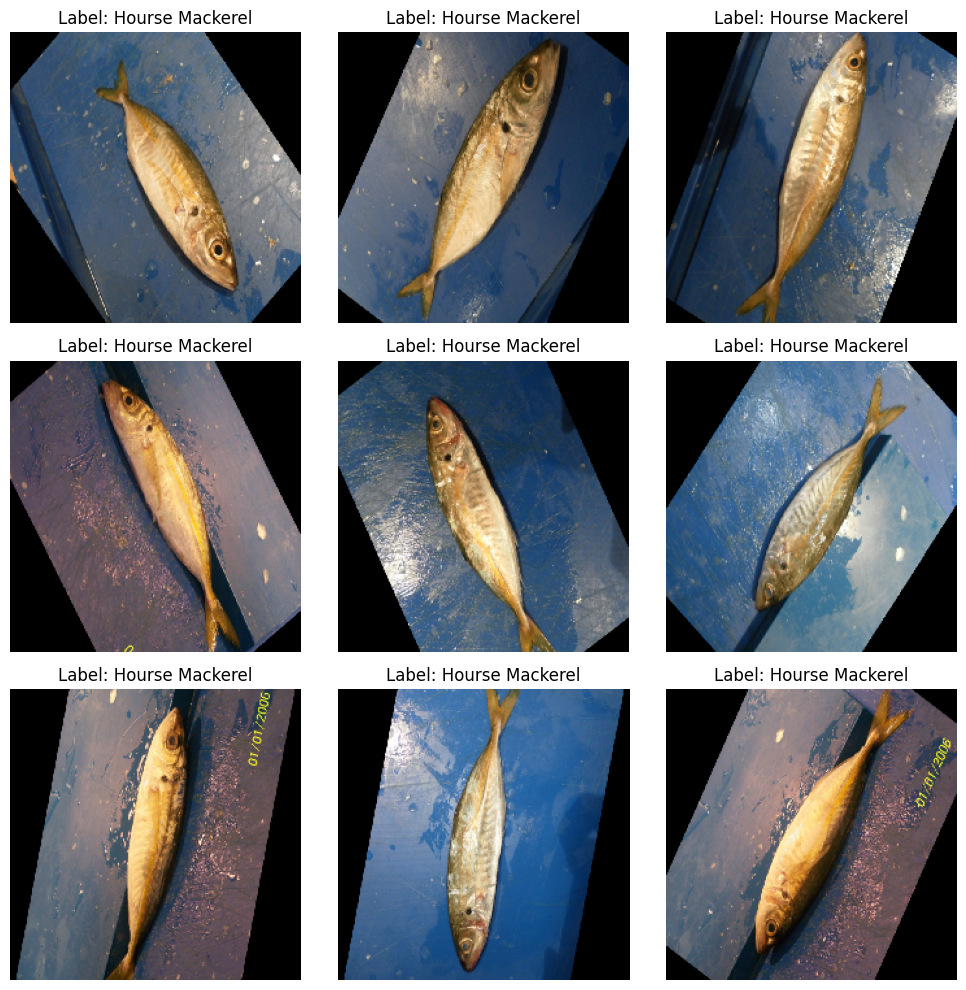

In [33]:
# İlk 9 resmi ve etiketleriyle beraber göstermek için
plt.figure(figsize=(10,10))

for i in range(9):
    # Görüntü yolu ve etiketini al
    img_path = data['path'][i]
    label = data['label'][i]
    
    # Görüntüyü yükle
    img = load_img(img_path, target_size=(224, 224))  # Görüntü boyutunu ayarla
    img_array = img_to_array(img) / 255.0  # Görüntüleri normalize et
    
    # 3x3 bir grid içinde görüntüleri yerleştir
    plt.subplot(3, 3, i+1)
    plt.imshow(img_array)
    plt.title(f'Label: {label}')
    plt.axis('off')

# Görselleri göster
plt.tight_layout()
plt.show()

5. Bu kod, veri setindeki toplam satır ve sütun sayısını öğrenir, kaç farklı balık türü olduğunu bulur ve bu türlerin isimlerini listeler.

In [34]:
# Veri setinin satır (row) ve sütun (column) sayısını öğrenme
num_rows, num_columns = data.shape
print(f"Veri setindeki satır sayısı: {num_rows}")
print(f"Veri setindeki sütun sayısı: {num_columns}")

# Kaç çeşit balık olduğunu öğrenme
unique_fish_species = data['label'].nunique()
print(f"Veri setindeki balık türü sayısı: {unique_fish_species}")

# Balık türlerinin isimlerini listeleme
fish_species = data['label'].unique()
print(f"Veri setindeki balık türleri: {fish_species}")

Veri setindeki satır sayısı: 9000
Veri setindeki sütun sayısı: 2
Veri setindeki balık türü sayısı: 9
Veri setindeki balık türleri: ['Hourse Mackerel' 'Black Sea Sprat' 'Sea Bass' 'Red Mullet' 'Trout'
 'Striped Red Mullet' 'Shrimp' 'Gilt-Head Bream' 'Red Sea Bream']


6. Bu kod, görüntü işleme sırasında kullanılacak parametreleri tanımlar:

- `batch_size = 32`: Model her iterasyonda 32 görüntü kullanacak

In [35]:
batch_size = 32
img_height = 224
img_width = 224

7. Bu kod, görüntüleri eğitim ve doğrulama (validation) için hazırlıyor:

- `train_datagen`: Eğitim ve doğrulama verilerini %255 ile ölçeklendirir ve veriyi ikiye böler (eğitim ve doğrulama için %80-%20).
- `train_generator`: Eğitim veri setini oluşturur.
- `validation_generator`: Doğrulama veri setini oluşturur.

Her iki veri seti de belirtilen görüntü boyutunda ve `batch_size` olarak 32 görüntü kullanılarak hazırlanır.

In [36]:
# Prepare data generators with rescaling and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)  # 20% data for validation
train_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical')

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


8. Bu kod, `train_generator` üzerinden eğitim veri setindeki sınıf sayısını (balık türü) alır ve bunu `num_classes` değişkenine atar. Sonrasında, bu sınıf sayısını ekrana yazdırır.

In [37]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

print(num_classes)

9


**BİRİNCİ MODEL**

9. Bu kod, bir Yapay Sinir Ağı (ANN) modeli oluşturur ve yapılandırır. Model, giriş katmanı, düzleştirme, birkaç tam bağlantılı (Dense) katman, dropout katmanları ve çıkış katmanından oluşur. Model 'adam' optimizasyonu ve 'categorical_crossentropy' kayıp fonksiyonu ile derlenir. `model_1.summary()` ile modelin yapısı özetlenir.

In [59]:
#  ANN model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# modelİ Compile edelim
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# modelözetini yazdıralım
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,236,233 (294.63 MB)

 Trainable params: 77,236,233 (294.63 MB)

 Non-trainable params: 0 (0.00 B)

10. Bu kod, oluşturulan ANN modelini eğitim verileriyle 10 epoch boyunca eğitir ve eğitim sırasında doğrulama verileri ile modelin performansını izler. Eğitim tamamlandıktan sonra model, doğrulama kümesinde değerlendirilir ve doğrulama doğruluğu (`val_accuracy`) yazdırılır. Eğitim işlemi GPU üzerinde gerçekleştirilir.

In [61]:
# modeli eğitelim
history = model.fit(
    train_generator,         
    validation_data=validation_generator,  
    epochs=15,               
    batch_size=batch_size,   
    verbose=1 )               
    

# Eğitimden sonra modeli doğrulama kümesinde değerlendirebiliriz
val_loss, val_acc = model.evaluate(validation_generator)

print(f'Validation accuracy: {val_acc}')

Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 136s 299ms/step - accuracy: 0.8290 - loss: 0.4868 - val_accuracy: 0.6456 - val_loss: 1.5410
Epoch 2/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 118s 260ms/step - accuracy: 0.8580 - loss: 0.3979 - val_accuracy: 0.6997 - val_loss: 1.0781
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 118s 259ms/step - accuracy: 0.8645 - loss: 0.3793 - val_accuracy: 0.6967 - val_loss: 1.1794
Epoch 4/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 119s 262ms/step - accuracy: 0.8845 - loss: 0.3185 - val_accuracy: 0.6953 - val_loss: 1.3716
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 118s 258ms/step - accuracy: 0.8884 - loss: 0.3207 - val_accuracy: 0.7756 - val_loss: 0.7042
Epoch 6/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 116s 255ms/step - accuracy: 0.8924 - loss: 0.2926 - val_accuracy: 0.7294 - val_loss: 1.0153
Epoch 7/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 117s 257ms/step - accuracy: 0.8960 - loss: 0.2943 - val_accuracy: 0.7708 - val_loss: 0.7756
Epoch 8/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 119s 261ms/step - accuracy: 0.9208 -

11. Bu kod, doğrulama verileri için modelin tahminlerini yapar ve gerçek etiketlerle karşılaştırarak sınıflandırma raporu oluşturur. Ayrıca, bir karışıklık matrisini (confusion matrix) oluşturup görselleştirir. Son olarak, eğitim ve doğrulama kayıplarını (loss) her epoch için çizerek modelin performansını analiz eder.

113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 318ms/step
Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.12      0.11      0.12       400
   Gilt-Head Bream       0.15      0.11      0.13       400
   Hourse Mackerel       0.11      0.11      0.11       400
        Red Mullet       0.08      0.09      0.08       400
     Red Sea Bream       0.11      0.15      0.13       400
          Sea Bass       0.14      0.11      0.12       400
            Shrimp       0.11      0.18      0.14       400
Striped Red Mullet       0.13      0.12      0.12       400
             Trout       0.13      0.07      0.09       400

          accuracy                           0.12      3600
         macro avg       0.12      0.12      0.11      3600
      weighted avg       0.12      0.12      0.11      3600



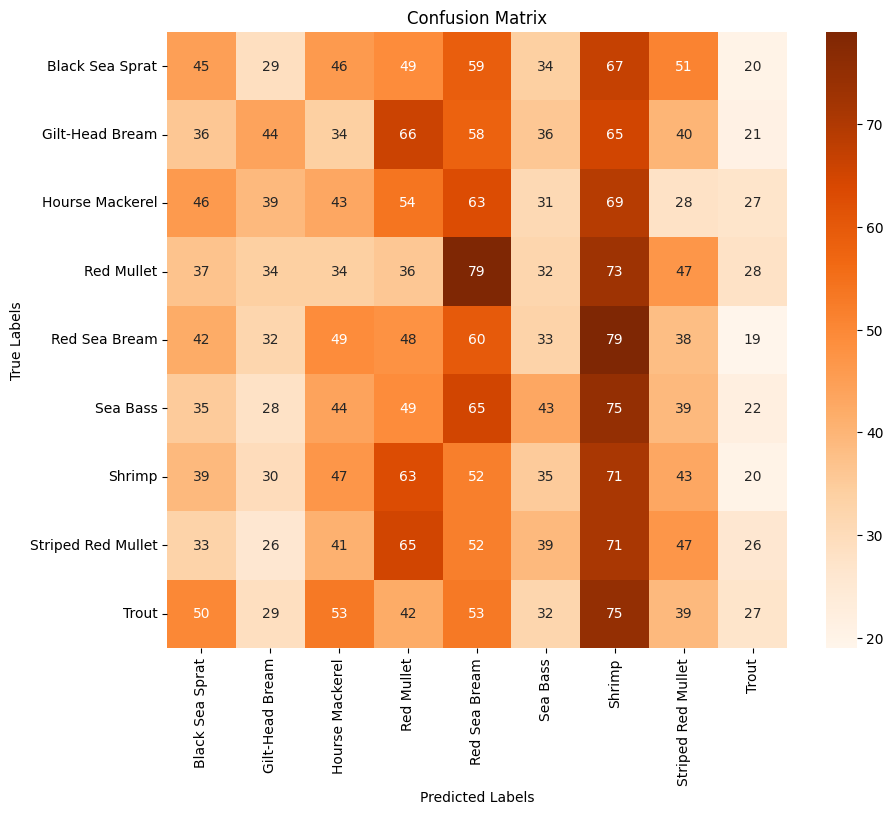

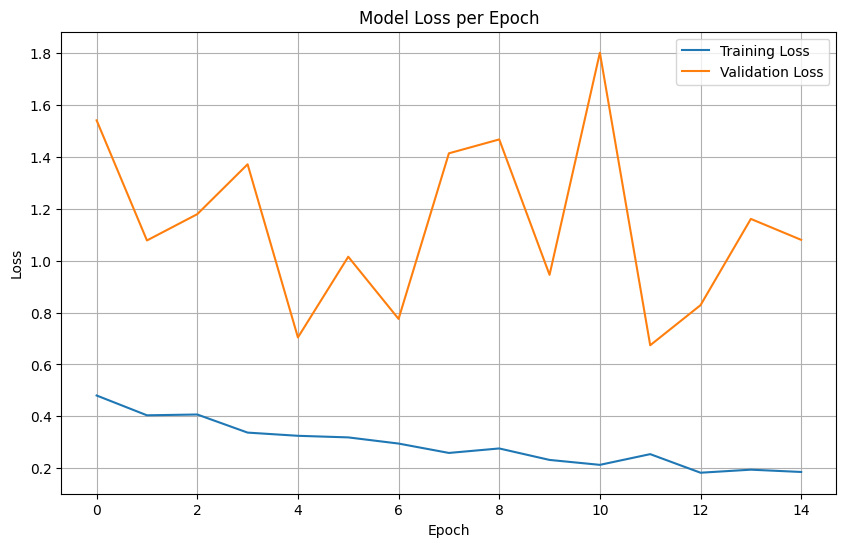

In [62]:
# Doğrulama verileri için etiketleri tahmin edelim
val_predictions = model.predict(validation_generator)
val_predictions = np.argmax(val_predictions, axis=1)  # Convert to label indices

# Doğrulama verileri için gerçek etiketleri alalım
true_labels = validation_generator.classes

# Sınıf etiketlerini (balık türü adları) alalım
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_labels, val_predictions, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, val_predictions)

# confusion matrix i görselleştirelim
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Eğitim ve doğrulama kaybı değerlerini çizelim
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

**SONUÇ: Modelin genel doğruluğu %75.7 olsa da, türler bazında performansı düşük. Precision, recall ve f1-skorları 0.11 ile 0.18 arasında değişiyor, bu da modelin tahminlerinin çoğu tür için yetersiz olduğunu gösteriyor. Genel doğruluk iyi görünse de, modelin tüm sınıflar arasında tutarlı bir performansı yok ve iyileştirmeye ihtiyaç var.**

**İKİNCİ MODEL**

12. Bu kod, **MobileNetV2** adlı önceden eğitilmiş bir modeli kullanarak bir transfer öğrenme süreci başlatır. Üst katmanlar olmadan modeli yükler ve temel modelin katmanlarını dondurarak yeniden eğitmeyi önler. Daha sonra, global havuzlama ve yoğun katmanlar ekleyerek kendi modelini oluşturur. Model, eğitim ve doğrulama verileriyle birlikte 5 epoch boyunca eğitilir ve sonuçları yazdırılır.

In [65]:
batch_size = 64  

base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,  
    weights='imagenet'  
)

# Yeniden eğitmeyi önlemek için temel modelin katmanlarını donduralım
base_model.trainable = False

# Özel üst katmanlar ekleyelim
model_transfer = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# modeli compile edelim
model_transfer.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model özetini yazdıralım
model_transfer.summary()

# modeli eğitelim
history_transfer = model_transfer.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  
    batch_size=batch_size,
    verbose=1
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 134s 271ms/step - accuracy: 0.7079 - loss: 0.8449 - val_accuracy: 0.9467 - val_loss: 0.1671
Epoch 2/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 119s 261ms/step - accuracy: 0.8827 - loss: 0.2974 - val_accuracy: 0.9567 - val_loss: 0.1267
Epoch 3/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 116s 256ms/step - accuracy: 0.9010 - loss: 0.2526 - val_accuracy: 0.9564 - val_loss: 0.1481
Epoch 4/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 120s 263ms/step - accuracy: 0.9155 - loss: 0.2077 - val_accuracy: 0.9611 - val_loss: 0.1182
Epoch 5/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 119s 262ms/step - accuracy: 0.9264 - loss: 0.1904 - val_accuracy: 0.9025 - val_loss: 0.3176


13. Bu kod, geliştirilmiş transfer öğrenme modelinin doğrulama veri kümesi üzerindeki performansını değerlendirir. `model_transfer.evaluate()` fonksiyonu, modelin doğrulama kaybını (`val_loss`) ve doğruluk oranını (`val_accuracy`) hesaplar ve ardından bu doğruluk oranını ekrana yazdırır. Bu, modelin ne kadar başarılı olduğunu ölçmek için kullanılır.

In [66]:
# Geliştirilmiş modeli değerlendirelim
val_loss, val_acc = model_transfer.evaluate(validation_generator)
print(f'Improved model validation accuracy: {val_acc}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 330ms/step - accuracy: 0.9015 - loss: 0.3392
Improved model validation accuracy: 0.9024999737739563


14. Bu kod, modelin eğitim kaybını grafikte gösterir, doğrulama verileri için tahminler yapar, sınıflandırma raporu ve karışıklık matrisi oluşturur ve sonuçları görselleştirir.

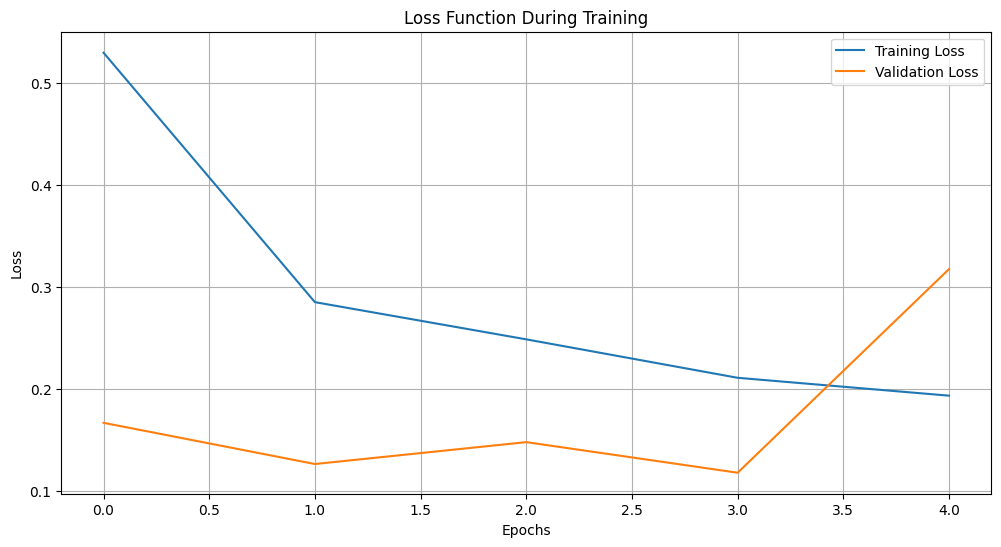

113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 346ms/step
Classification Report:
                     precision    recall  f1-score   support

   Black Sea Sprat       0.11      0.10      0.10       400
   Gilt-Head Bream       0.13      0.16      0.14       400
   Hourse Mackerel       0.11      0.09      0.10       400
        Red Mullet       0.11      0.11      0.11       400
     Red Sea Bream       0.11      0.09      0.10       400
          Sea Bass       0.10      0.13      0.11       400
            Shrimp       0.10      0.11      0.10       400
Striped Red Mullet       0.13      0.12      0.13       400
             Trout       0.13      0.12      0.12       400

          accuracy                           0.11      3600
         macro avg       0.11      0.11      0.11      3600
      weighted avg       0.11      0.11      0.11      3600



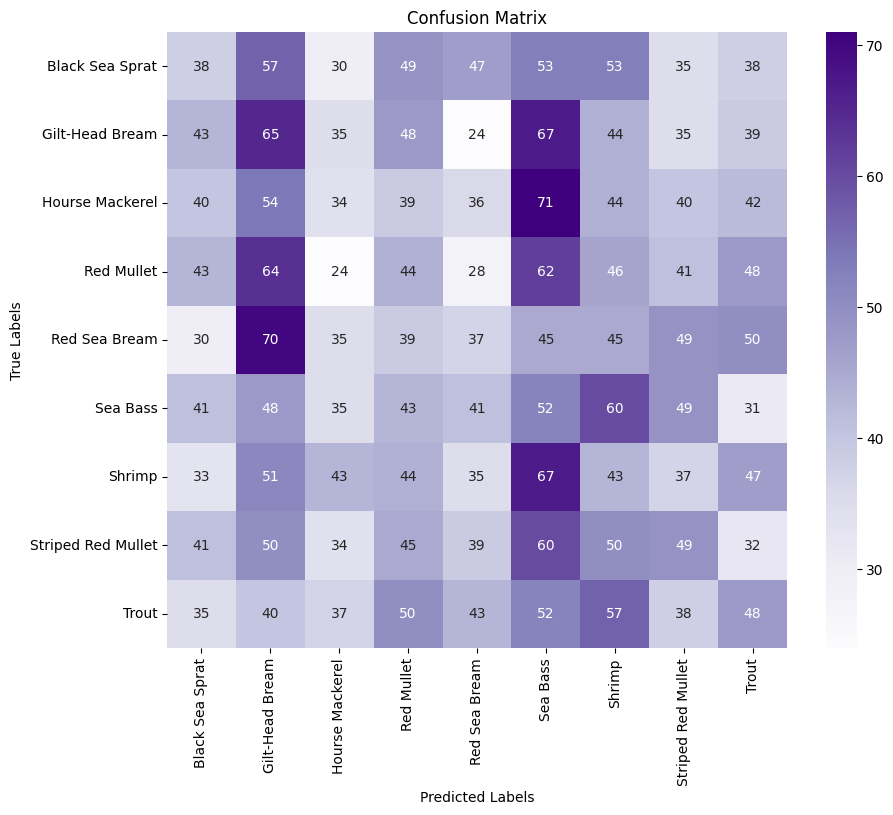

In [67]:
# kayıp fonksiyonunu görselleştirelim
plt.figure(figsize=(12, 6))
plt.plot(history_transfer.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Loss Function During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Doğrulama verileri için tahminler oluşturalım
y_pred = model_transfer.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

#  true etiketleri getirelim
y_true = validation_generator.classes

# classification report
report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print("Classification Report:\n", report)

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# confusion matrix i görselleştirelim
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**SONUÇ: Bu sonuçlar, modelin doğrulama doğruluğunun %90.2'ye yükseldiğini gösteriyor, yani model genel olarak veri setini iyi tanımlıyor. Ancak, classification report'a göre tür bazında modelin performansı hala düşük. Precision, recall ve f1-skorları türler arasında %9 ile %16 arasında değişiyor. Bu da modelin bazı türleri doğru sınıflandırmakta zorlandığını, genel doğruluğun yüksek olmasına rağmen türler arasında dengesiz bir performans olduğunu gösteriyor. Model, belirli balık türleri üzerinde daha fazla iyileştirmeye ihtiyaç duyuyor.**